### Задача

Аугментация изображений аннотация которых прописана в csv файле, лейблы закодированы в векторе состоящем из нулей и единиц. Применить отобранные аугментации и распаралелить обработку на `n` процессов.

**Применить все аугментации к изображению.**

### Multiproc generate

In [8]:
import os
import cv2
import shutil
import numpy as np
from PIL import Image
import pandas as pd
from pathlib import Path
import albumentations as A
from random import choice
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool

### Transformations

In [9]:
transformations = {
    'Rotate': A.Rotate(limit=25, border_mode=cv2.BORDER_CONSTANT, always_apply=True),
    'RandomScale': A.RandomScale(scale_limit=0.5, always_apply=True),
    'HorizontalFlip': A.HorizontalFlip(always_apply=True),
    'Perspective': A.Perspective(always_apply=True),
    'PixelDropout': A.PixelDropout(always_apply=True),
    'ShiftScaleRotate': A.ShiftScaleRotate(always_apply=True, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT),
    'RandomBrightnessContrast': A.RandomBrightnessContrast(always_apply=True),
    'RandomGamma': A.RandomGamma(always_apply=True),
    'RandomShadow': A.RandomShadow(always_apply=True),
    'RandomToneCurve': A.RandomToneCurve(always_apply=True),
    'RingingOvershoot': A.RingingOvershoot(always_apply=True),
    'Blur': A.Blur(always_apply=True),
    'CLAHE': A.CLAHE(always_apply=True),
    'Downscale': A.Downscale(always_apply=True),
    'Emboss': A.Emboss(always_apply=True),
    'FancyPCA': A.FancyPCA(always_apply=True),
    'GaussNoise': A.GaussNoise(always_apply=True),
    'GaussianBlur': A.GaussianBlur(always_apply=True),
    'GlassBlur': A.GlassBlur(always_apply=True),
    'HueSaturationValue': A.HueSaturationValue(always_apply=True),
    'ISONoise': A.ISONoise(always_apply=True),
    'ImageCompression': A.ImageCompression(always_apply=True),
    'MedianBlur': A.MedianBlur(always_apply=True),
    'MotionBlur': A.MotionBlur(always_apply=True),
    'MultiplicativeNoise': A.MultiplicativeNoise(always_apply=True),
    'RGBShift': A.RGBShift(always_apply=True),
    'RingingOvershoot': A.RingingOvershoot(always_apply=True),
    'Sharpen': A.Sharpen(always_apply=True),
    'ToGray': A.ToGray(always_apply=True),
    'UnsharpMask': A.UnsharpMask(always_apply=True)
}

/home/jovyan/.cache/pypoetry/virtualenvs/s-iner-cv-clf-multi-decor-v0-1-pie6eGIx-py3.10/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


### Functions

In [10]:
# откуда берем исходные аннотации
path_ann = '../data/datasets/csv/train.csv'
# название аугментированного датасета
dir_save_dataset = '../data/datasets/augoff'

Создадим структуру для сохранения изображений и аннотации.

In [11]:
num_transformations = len(transformations)

dir_save_dataset
if os.path.exists(dir_save_dataset):
    shutil.rmtree(dir_save_dataset)
    
dir_save_dataset_imgs = f'{dir_save_dataset}/images'
if not os.path.exists(dir_save_dataset_imgs):
    os.makedirs(dir_save_dataset_imgs)
    
dir_save_dataset_anns = f'{dir_save_dataset}/annotations'
if not os.path.exists(dir_save_dataset_anns):
    os.makedirs(dir_save_dataset_anns)

`task` - возьмет строку из DataFrame, сохранит оригинальное и трансформированные изображения и аннотации к ним.

In [12]:
path_imgs = '../data/datasets/original/images/default'

In [13]:
def task(indx: int) -> dict:
    
    row = df.iloc[indx, :]

    path_img = f'{path_imgs}/{row["file_name"]}.jpg'

    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # сохраним оригинальное изображение
    cv2.imwrite(f'{dir_save_dataset_imgs}/Original_{row["file_name"]}.jpg', img[:,:,::-1])
    
    data = []
    # сохраним разметку оригинального изображения
    dict_row = dict(row)
    dict_row['file_name'] = f'Original_{row["file_name"]}'
    data.append(dict_row)
    
    for key in transformations.keys():
        # если возникнет ошибка для какого-то изображения какой-то генерации, то не делать данную трансформацию
        try:        
            transform = transformations[key]
            transformed = transform(image=img)
            cv2.imwrite(f'{dir_save_dataset_imgs}/{key}_{row["file_name"]}.jpg', transformed['image'][:,:,::-1])

            dict_row = dict(row)
            dict_row['file_name'] = f'{key}_{row["file_name"]}'
            
            data.append(dict_row)
            
        except:
            print(f'Problem | Transform: {key}')
    return data

### Augmentation

Аугментируем тренировочный датасет.

In [14]:
df = pd.read_csv(path_ann)
num_rows = len(df)

with Pool(os.cpu_count()-40) as p: 
    results = list(tqdm(p.imap(task, range(num_rows)), total=num_rows))

res = [dict_row for list_results in results for dict_row in list_results]
df = pd.DataFrame(res)
df.to_csv(f'{dir_save_dataset_anns}/{Path(path_ann).name}', index=False)

100%|██████████| 13617/13617 [25:00<00:00,  9.08it/s]


### Визуальная проверка

In [36]:
import os
import cv2
import json
import shutil
import numpy as np
from PIL import Image
import pandas as pd
from pathlib import Path
import albumentations as A
from random import choice
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [16]:
def get_optimal_font_scale(text: str, width: int, scaling_weight: float) -> float:
    for scale in reversed(range(0, 60, 1)):
        textSize = cv2.getTextSize(text, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=scale/scaling_weight, thickness=1)
        new_width = textSize[0][0]
        if (new_width <= width):
            return scale/scaling_weight/5
    return 1.0

In [17]:
def draw_labels(
    frame: np.array,
    label_prob: list,
    max_labels_on_image: float = 8,
    alpha: float = 0.8,
    line_shift: float = 0.05
) -> np.array:

    h, w = frame.shape[:2]

    overlay = frame.copy()

    x, y = 0, 100
    h_rect = int(h*0.1*max_labels_on_image)
    w_rect = int(w*0.22)

    if w + h > 2000:
        scaling_weight = 10
    elif 1000 < w + h < 2000:
        scaling_weight = 20
    elif 500 < w + h < 2000:
        scaling_weight = 35
    else:
        scaling_weight = 45

    cv2.rectangle(overlay, (x, y), (x+w_rect, y+h_rect), (0, 0, 0), -1)

    image_with_rect = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)

    for i, text in enumerate(label_prob, start=1):

        cv2.putText(
            image_with_rect,
            text,
            (int(x+(w_rect*0.1)), y+(i*int(h_rect*line_shift))),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=get_optimal_font_scale(text, w, scaling_weight),
            color=(255, 255, 255),
            thickness=round((w * h) / (1000 * 1000))
        )
        
    return image_with_rect

In [32]:
path_anns = '../data/datasets/original/annotations/default.json'

In [33]:
def display_random_image(path_ann: str, name_transform: str = None) -> None:
    
    df = pd.read_csv(path_ann)
    
    if name_transform:
        df = df[df['file_name'].str.contains(f'^{name_transform}*') == True].reset_index(drop=True)
    
    with open(path_anns, 'r') as f:
        data = json.load(f)

    list_labels = np.array([d['name'] for d in data['categories']['label']['labels']])
    # list_labels = np.array(
    #     [
    #         'room', 'bathroom', 'inner_corridor', 'public_place', 'floor_finish',
    #     'floor_init', 'ceiling_finish', 'wall_finish', 'wall_init', 'door_yes',
    #     'toilet_yes', 'bath_yes', 'esocket_yes', 'kitchen_furniture_yes',
    #     'radiator', 'floor_without', 'ceiling_without', 'wall_without',
    #     'window_trim', 'window', 'floor_pipes', 'garbage', 'place_door',
    #     'place_radiator', 'place_toilet', 'place_sink', 'place_bath',
    #     'ventilation_shaft', 'sink_yes', 'conditioner', 'smoke_detector',
    #     'ventilation_grille', 'fire_detectors', 'dynamics', 'switch_box_flat',
    #     'switch_box_public'
    #     ]
    # )
    
    k = choice(range(len(df)))
    file_name = df.iloc[k, :]['file_name']
    print(f'Transformation: {file_name.split("_")[0]}')
    mask = df.iloc[k, 1:].values.astype(bool)
    labels = list_labels[mask]
    
    path_img = f'{path_imgs}/{file_name}.jpg'
    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = draw_labels(img, labels)
    
    plt.figure(figsize=(18, 10))
    plt.imshow(img)

In [34]:
# пути на аугментированный датасет
path_ann = '../data/datasets/augoff/annotations/train.csv'
path_imgs = '../data/datasets/augoff/images'

Transformation: HueSaturationValue


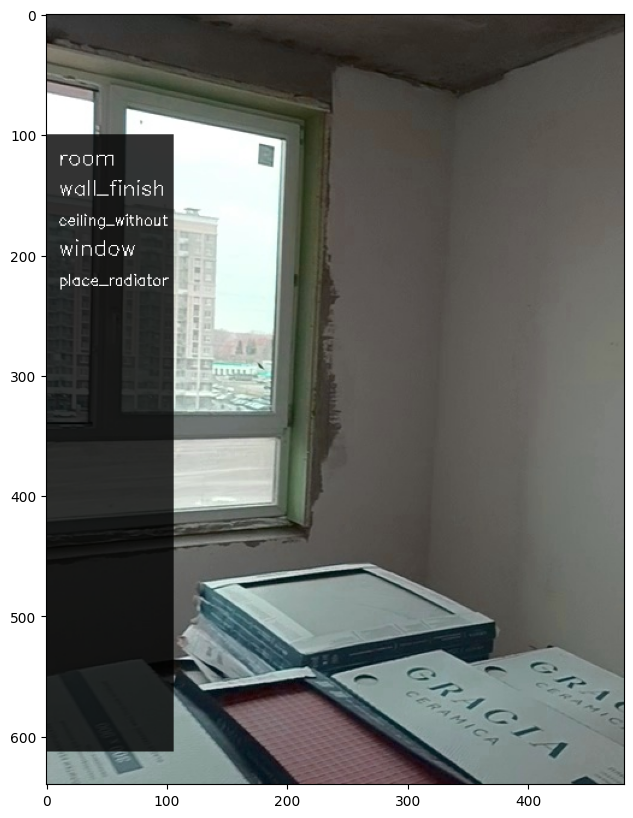

In [40]:
name_transform = None
#name_transform = 'HueSaturationValue'

display_random_image(path_ann, name_transform)

### Анализ датасета

Посчитать количество трансформаций.

In [41]:
#path_ann = '../../data/augoff_mvp171122/annotations/train.csv'

path_ann = '../data/datasets/augoff/annotations/train.csv'

In [42]:
print(f'Total images: {len(df)}')

Total images: 408510


In [43]:
df = pd.read_csv(path_ann)

transformations = [row['file_name'].split('_')[0] for i, row in df.iterrows()]
names, num = np.unique(transformations, return_counts=True)    

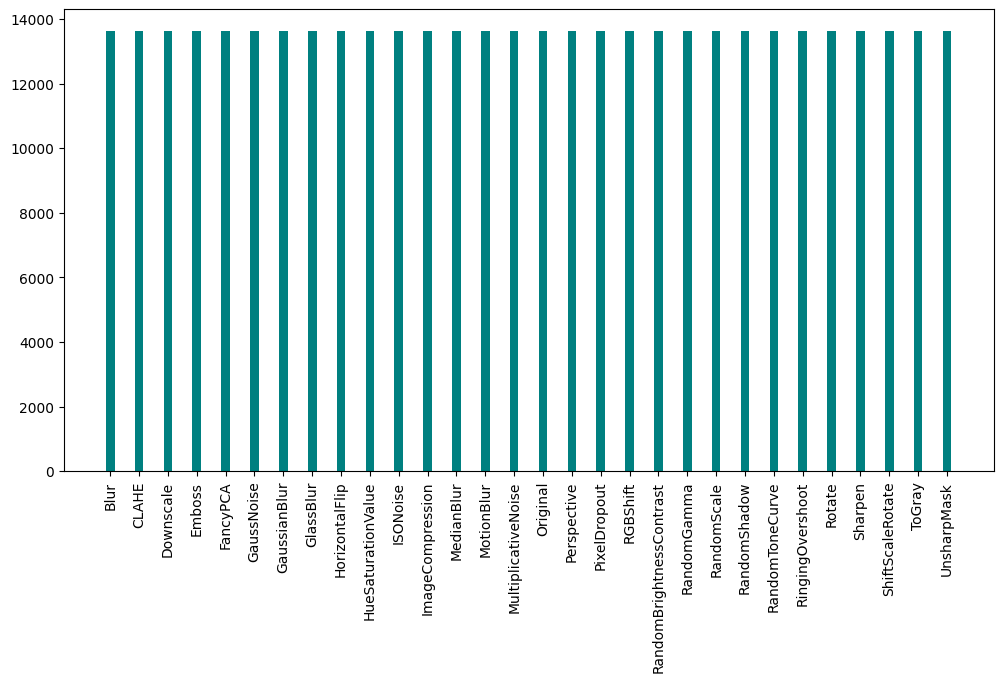

In [44]:
width = 0.3
fig, ax = plt.subplots()

fig.set_figwidth(12)
fig.set_figheight(6)

ax.bar(names, num, width, color='teal',)
plt.xticks(rotation=90);